Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

Plot a confusion matrix for your Tanzania Waterpumps model

In [3]:
import numpy as np
from sklearn.metrics import plot_confusion_matrix

In [4]:
def wrangle (df):
    # Prevent warning
    df = df.copy(deep=True)

    # Date time conversion
    df['date_recorded'] = pd.to_datetime(df['date_recorded'])
    df['date_recorded_year'] = df['date_recorded'].dt.year
    df['date_recorded_month'] = df['date_recorded'].dt.month
    df['date_recorded_day'] = df['date_recorded'].dt.day
    
    # Deal with outliers
#     df['population'] = (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
#        (df['latitude'] < np.percentile(df['latitude'], 99.95)) 
#     df['num_private'] = might as well be tossed if all non-zeros are trimmed
#     df['amount_tsh'] = 
    
    # Fix zeros
    def fix_zeros (col):
        df[col][df[col]==0] = np.NaN
    
    fix_zeros('longitude')
    fix_zeros('latitude')
    fix_zeros('construction_year')
    fix_zeros('gps_height')
    
    # Engineer feature
    df['Age'] = df['date_recorded_year'] - df['construction_year']
    df['region_district_comb'] = df['region_code']*100 + df['district_code']
    
    # select dropped cols and return
    drops = ['date_recorded','id','recorded_by', 'wpt_name']
    return df.drop(columns=drops)

train_wrangled = wrangle(train)
test_wrangled = wrangle(test)

C:\Users\Owner\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [11]:
# Split train into train & val. Make val the same size as test.
target = 'status_group'
train, val = train_test_split(train_wrangled, test_size=len(test),  
                              stratify=train_wrangled[target], random_state=42)

# Arrange data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

# Make pipeline!
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
pipeline.score(X_val,y_val)

0.810767516367182

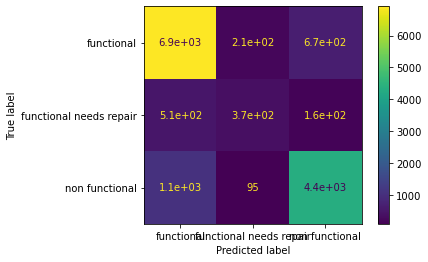

In [13]:
plot_confusion_matrix(pipeline,X_val,y_val);